# Skill assessment
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 27-06-2023<br>


**Introduction**:<br>
In this notebook I will analyse the EFAS skill in predicting flood events in general, i.e., looking whether events where predicted at some point in time, regardless of neither the offset nor the duration of the event.

**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import cartopy.crs as ccrs
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
os.environ['USE_PYGEOS'] = '0'
import pickle
import yaml
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, KFold

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from compute import *
#from compute import hits2skill, define_area_ranges, hits_by_area, summarize_by_area
from convert import dict2da
from optimize import find_best_criterion, find_best_criteria, find_best_criteria_cv
from plot.results import lineplot_hits, lineplot_skill, plot_skill_training, plot_hits_by_variable, plot_skill_by_variable
from plot.maps import create_cmap, map_stations, map_hits, map_skill, map_events
os.chdir(path_root)

In [2]:
# Set the default text font size
plt.rc('font', size=15)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=15)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=13)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=13)
# Set the legend font size
plt.rc('legend', fontsize=13)
# Set the font size of the figure title
plt.rc('figure', titlesize=17)

## 1 Configuration

In [3]:
with open("../conf/config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### 1.1 Reporting points

In [4]:
# area threshold
area_threshold = cfg.get('reporting_points', {}).get('area', 500)

# reporting points
path_stations = cfg.get('reporting_points', {}).get('output', '../results/reporting_points/')
file_stations = f'{path_stations}reporting_points_over_{area_threshold}km2.parquet'

# catchments
catchments = cfg.get('reporting_points', {}).get('catchments', None)

# minimum performance required from the reporting points
min_kge = cfg.get('reporting_points', {}).get('KGE', None)

### 1.2 Hits

In [5]:
# parameters of the rolling window used to compute hits
window = cfg.get('hits', {}).get('window', 1)

# dissagregate the analysis by seasons?
seasonality = cfg.get('hits', {}).get('seasonality', False)

# path that contains the NetCDFs with hit, misses and false alarms pro
path_in = cfg.get('hits', {}).get('output', '../results/hits/')
path_in = f'{path_in}window_{window}/'

### 1.3 Skill

In [6]:
# current operationa criteria
current_criteria = cfg.get('skill', {}).get('current_criteria', None)

# fixed notification criteria
min_leadtime = cfg.get('skill', {}).get('leadtime', 60)
min_area = cfg.get('skill', {}).get('area', 2000)

# coefficient of the fbeta-score
beta = cfg.get('skill', {}).get('beta', 1) #[.8, 1, 1.2]
metric = f'f{beta}'

# optimization parameters
kfold = cfg.get('skill', {}).get('optimization', {}).get('kfold', None)
train_size = cfg.get('skill', {}).get('optimization', {}).get('train_size', .8)
stratify = cfg.get('skill', {}).get('optimization', {}).get('stratify', False)
tolerance = cfg.get('skill', {}).get('optimization', {}).get('tolerance', 1e-2)
min_spread = cfg.get('skill', {}).get('optimization', {}).get('minimize_spread', True)

# path where results will be saved
path_out = cfg.get('skill', {}).get('output', f'../results/skill/')
if min_kge is not None:
    path_out = f'{path_out}window_{window}/kge_{min_kge}/'
else:
    path_out = f'{path_out}window_{window}/no_kge/'
for path in [path_out, f'{path_out}{metric}/']:
    if os.path.exists(path) is False:
        os.makedirs(path)

## 2 Data
### 2.1 Reporting points

In [7]:
# load table of fixed reporting points
stations = pd.read_parquet(file_stations)
stations[['X', 'Y', 'area']] = stations[['X', 'Y', 'area']].astype(int)

# select stations that belong to the selected catchments
if catchments is not None:
    if isinstance(catchments, list) is False:
        catchments = [catchments]
    stations = stations.loc[stations.catchment.isin(catchments),:]

# remove points with a performance (KGE) lower than the established threshold
if min_kge is not None:
    mask_kge = ~(stations.KGE <= min_kge)
    stations = stations.loc[mask_kge]
else:
    # remove station with erroneous behaviour
    stations = stations.loc[~(stations.n_events_obs >= 6)]

In [8]:
# mask stations with events
stations_w_events = (stations.n_events_obs > 0)

print('All points')
print('----------')
print(f'no. reporting points:\t\t{stations.shape[0]}')
print('no. stations with events:\t{0}'.format(stations_w_events.sum()))
print('no. observed events:\t\t{0}'.format(stations.n_events_obs.sum()))

# select stations according to catchment area
if min_area > area_threshold:
    stations_optimize = stations.loc[stations.area >= min_area].index
else:
    stations_optimize = stations.index

print('\nPoints selected for otimization')
print('-------------------------------')
print(f'no. reporting points:\t\t{len(stations_optimize)}')
print('no. stations with events:\t{0}'.format((stations.loc[stations_optimize, 'n_events_obs'] > 0).sum()))
print('no. observed events:\t\t{0}'.format(stations.loc[stations_optimize, 'n_events_obs'].sum()))

# suffix that will be used when saving plots
suffix = f'{min_area}km2_{len(stations_optimize)}points'

All points
----------
no. reporting points:		1979
no. stations with events:	831
no. observed events:		1264

Points selected for otimization
-------------------------------
no. reporting points:		1239
no. stations with events:	480
no. observed events:		678


**Distribution of catchment area**

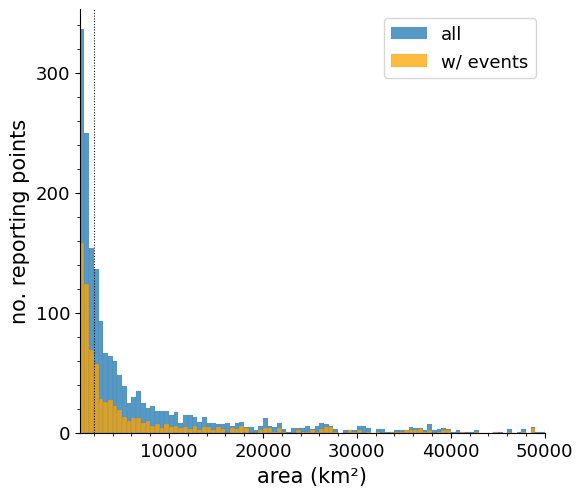

In [9]:
xmin = area_threshold
xmax = 500001#np.ceil(stations.area.max() / 500) * 500
bins = np.arange(xmin, xmax, 500).astype(int)

fig, ax = plt.subplots(figsize=(6, 5.5))
sns.histplot(stations.area, ax=ax, bins=bins, label='all')
sns.histplot(stations[stations_w_events].area, ax=ax, color='orange', bins=bins, label='w/ events')
ax.axvline(min_area, color='k', ls=':', lw=.75)
ax.set(xlabel='area (km²)', ylabel='no. reporting points', xlim=(xmin, 50000));
ax.xaxis.set_major_locator(MultipleLocator(10000))
ax.xaxis.set_minor_locator(MultipleLocator(2000))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(20))
ax.spines[['right', 'top']].set_visible(False)
ax.legend();

plt.savefig(f'{path_out}area_distribution_{suffix}.jpg', dpi=300, bbox_inches='tight')

> ***Figure 1**. Distribution of the reporting points according to catchment area. The complete set of reporting points is shown in blue, and the subset of reporting points with observed flood events during the study period is shown in red. The balck, dotted line represents the minimum catchment area that will be used for the optimization of the notification criteria.*

Two ideas to extract from the previous plot:

* When considering all the catchment areas, only **41% of the fixed reporting points had a flood event** during the study period. This figure is very similar (37%) when considering points with a catchment area larger than 2000 km².

* **40% of the fixed reporting points have a catchment area smaller than 2000 km²**, therefore the are excluded from the optimization.

**Map of number of "observed" events**

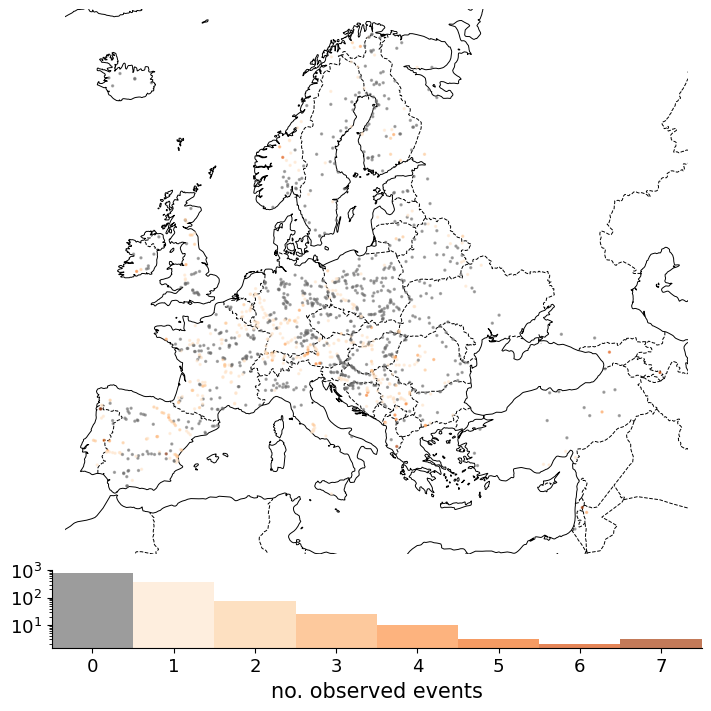

In [10]:
# map_events(stations, 'n_events_obs', yscale='log', save=f'{path_out}/map_observed_events_500km2_{stations.shape[0]}.jpg')
map_events(stations.loc[stations_optimize], 'n_events_obs', yscale='log', save=f'{path_out}/map_observed_events_{suffix}.jpg')

> ***Figure 2**. Number of observed flood events during the study period.*

The geographical distribution of events is not even. There is a higher proportion of stations with events in Central Europe, British Isles and the Mediterranean catchments than in Estearn and North-Eastern Europe. During the study period there were major events in the Rhine, Meuse and Ebro, which can be seen in the map.

The reporting points with more than 5 flood events during the study period were removed, since it is suspicious that the 5-year return period was exceeded so many times in only 2 years of study period.

### 2.2 Hits, misses and false alarms

In [11]:
# import hits for each station
hits_stn = xr.open_mfdataset(f'{path_in}*.nc', combine='nested', concat_dim='id')

# extract selected stations
stations = stations.loc[set(stations.index).intersection(hits_stn.id.data)]
hits_stn = hits_stn.sel(id=stations.index.to_list()).compute()

# convert to NaN lead times that can't be reached due to model limitations or persistence
hits_stn = limit_leadtime(hits_stn)

# subset of the 'hits' dataset with the stations selected for the optimization
stations_optimize = list(set(stations_optimize).intersection(hits_stn.id.data))
hits_opt = hits_stn.sel(id=stations_optimize).sum('id', skipna=False)

## 3 Analysis

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: $recall$, $precision$ and the $f_{beta}$ score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f_{beta} = \frac{(1 + \beta^2) \cdot TP}{(1 + \beta^2) \cdot TP + \beta^2 \cdot FN + FP}$$

### 3.1 Skill computation

In [12]:
# skill by station
skill_stn = hits2skill(hits_stn, beta=beta)

# skill dataset for optimizing criteria
skill_opt = hits2skill(hits_opt, beta=beta)

### 3.2 Analyse overall performance

In [13]:
# to simplify the plot, they will show only the following values of persistence and leadtime
persistences = ['1/1', '2/2', '3/3']
leadtimes = skill_opt.leadtime.data # [12, 36, 60, 84]#, 108, 132]

#### 3.2.1 Hits, misses and false alarms

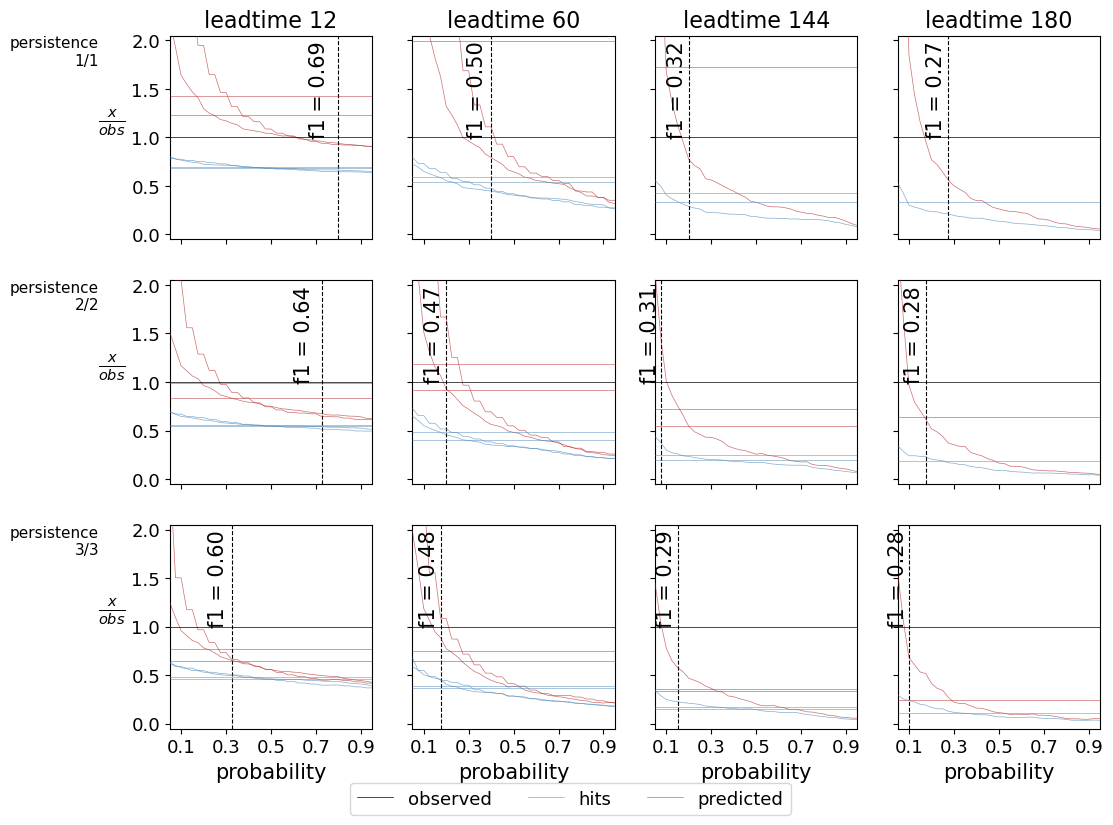

In [14]:
lineplot_hits(hits_opt.sel(persistence=persistences, leadtime=leadtimes),
              coldim='leadtime', rowdim='persistence', linedim='model',
              ylim=(-.05, 2.05), xticks=hits_opt.probability.data[2::8],
              loc_legend=[0.15, -.04, .5, .1],
              save=f'{path_out}{metric}/hits_lineplot_persistenceVSleadtimeVSprobability_{suffix}.jpg')

> ***Figure 3**. Evolution of hits, misses and false alarms depending on probability (X axis), persistence (rows), and lead time (columns). The Y axis is normalized by the number of observed events. The black, horizonal line, which represents the number of observed events, is the reference. Blue lines represent the hits (TP) for each of the approaches to combine the meteorological forecasts; the difference between the reference line and these blue lines are the misses (events that were not forecasted). Red lines represent the total number of prediced events; therefore, the difference between them and the blue lines are the false alarms (wrongly predicted events). The vertical, dashed line indicates the probability threshold that maximizes skill, including the skill value.*

The first outcome of this plot is that no matter the combination of criteria, we cannot predict all the observed events. Even for the shortest leadtime, lowest probability threshold and most relaxed persistency, the hit rate ($\frac{hits}{obs}$) is around 0.80. However, to achieve this hit rate value, the false hit rate ($\frac{pred-hits}{obs}$) is dramatically large. In fact, since our target skill metric is $f_{beta}$, we want to optimize a combination of those two rates; the result is that we need to allow for a lower hit rate in order not to minimize the amount of false alarms.

If we analyse the evolution regarding thre three variables (lead time, persistence and probability), we get the following conclusions:

* **Lead time**. As expected, skill improves with shorter leadtimes, as the uncertainty in the prediction dicreases.

* **Persistence**. There is a clear tendency to overpredict especially for lower probability thresholds, where the total amount of prediced events go well beyond the number of observed events. The main role of persistency is to limit this overprediction.

* **Probability**. It plays a similar role as persistence. By increasing the probability threshold we reduce the number of false alarms. The optimal value of probability is the one that comprimises correctly the number of hits, misses and false alarms. Since probability and persistence play a similar role, there is a trade-off between those two variables. Whenever persistence is more relaxed (or non-existen), the probability threshold is higher; and viceversa. For a fixed persistence, the optimal probability threshold is higher for shorter lead times; since the uncertainty on the prediction is lower, the probability threshold can be higher.

* **Approach**. The hit rate is fairly similar regarless of the method used to combine the meteorological forcings. On the contray, the false hit rate is very sensitive to the approach, especially with more relaxed persistence.

#### 3.2.2 Skill: recall, precision and fbeta

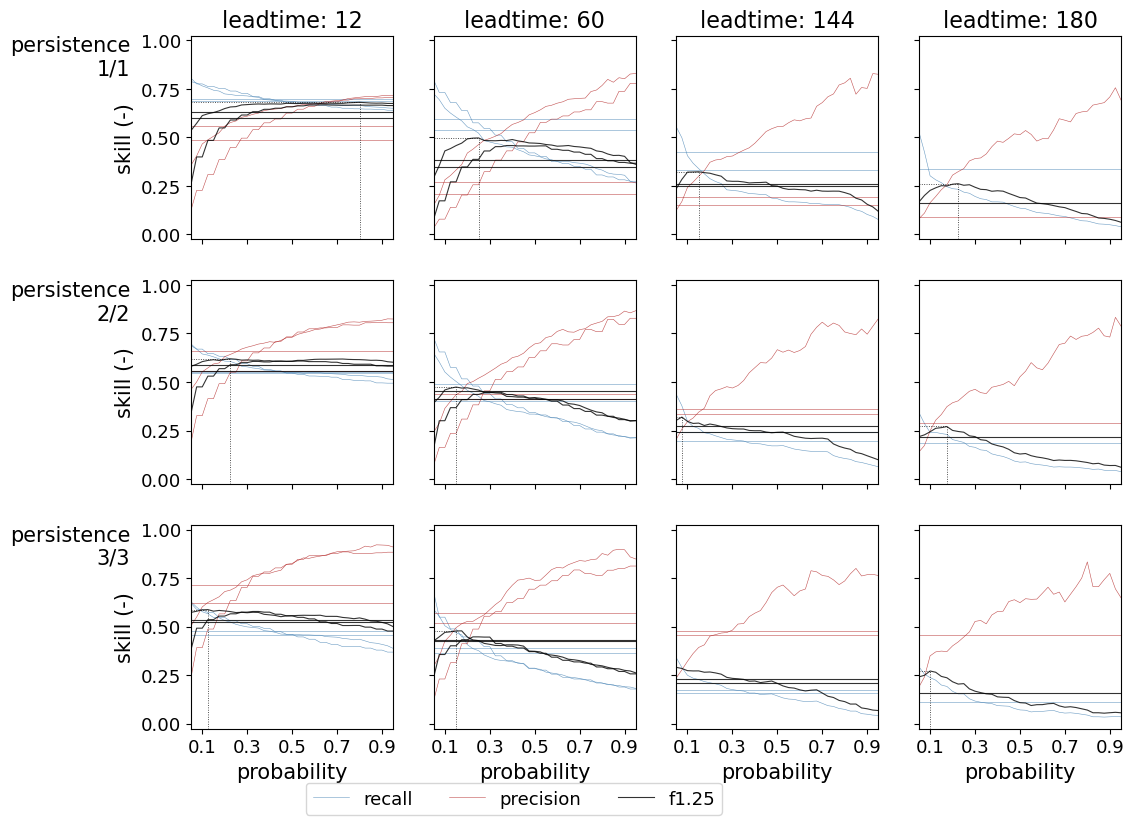

In [15]:
lineplot_skill(skill_opt.sel(persistence=persistences, leadtime=leadtimes),
               metric=metric, coldim='leadtime', linedim='model',
               xticks=skill_opt.probability.data[2::8],
               save=f'{path_out}{metric}/skill_lineplot_persistenceVSleadtimeVSprobability_{suffix}.jpg')

> ***Figure 4**. Evolution of skill depending on probability (X axis), persistence (rows), and lead time (columns). Black lines represents the the target skill metric for each of the approaches to combine the meteorological forecasts, which is a combination of recall (blue lines) and precision (red lines). The dotted lines represent the optimal probability threshold and the associated value of the target metric.*

The plot shows the well known interplay between recall and precision. In this case, recall is high for small probability thresholds; when this threshold is low, the system produces more notifications and the number of misses reduces. On the other hand, precision is high for large probability thresholds; notifications are sent only when the certainty of the event is high, so the number of false alarms is minimum.

The target metric is a combination of both recall and precision. For that metric, we look for the optimal probability threshold. Fortunately, in the majority of plots we see that the target metric (black lines) has a convex curve, so it is possible to find the optimal value. Only for very short lead time and more relaxed persitence the target metric has a continuously increasing behaviour.

The conclusions regarding each of the four variables are similar as before:

* **Lead time**. Skill increases with lead time. As said before, lead time also influences the optimal probability threshold, with larger values for shorter lead times.

* **Persistence**. Skill reduces with persistence. It also affects the optimal probability threshold, with higher values for more relaxed persistence.

* **Probability**. As explained before, in most of the combinations of persistence and leadtime the target skill metric shows a convex behaviour in relation with probability. 

* **Approach**. The difference among the approaches is noticeable only when persistence is relaxed. For instance, for no persistence (persistence 1/1), the _model mean_ behaves clearly different from the other approaches.

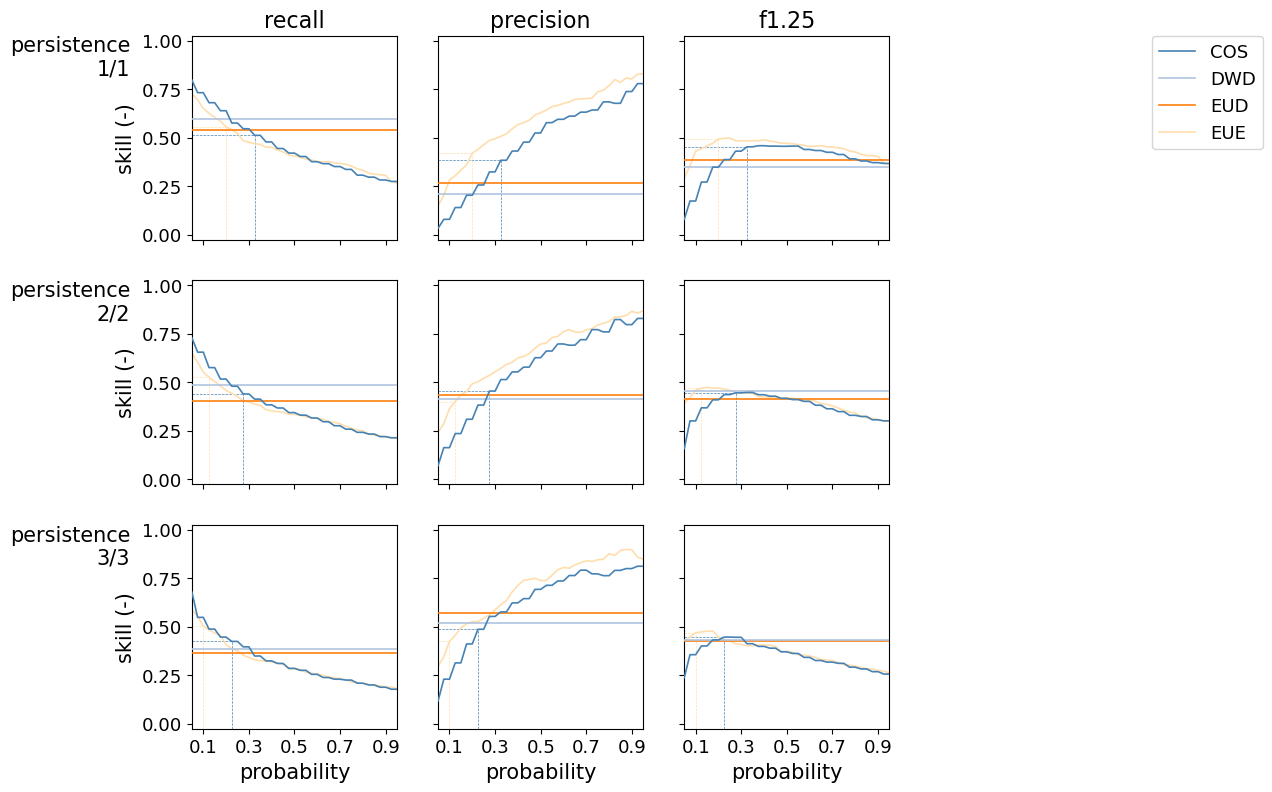

In [16]:
# skill for a fixed lead time
leadtime = 60
lineplot_skill(skill_opt.sel(persistence=persistences, leadtime=leadtime),
               metric=metric, coldim=None, linedim='model',
               xticks=skill_opt.probability.data[2::8], linewidth=1.2, alpha=1,
               loc_legend=[1.125, .79, .2, .1], color={'COS': 'steelblue', 'DWD': 'lightsteelblue', 'EUD': 'C1', 'EUE': 'navajowhite'},
               save=f'{path_out}{metric}/skill_lineplot_persistenceVSprobability_{suffix}_{leadtime}h_comparison_fscores.jpg')

> ***Figure 5**. Evolution of skill depending on probability (X axis) and persistence (rows). Each column represents a skill metric. In each plot the solid lines represent the approaches to combine the meteorological forcings. The dotted lines represent probability threshold optimized for the target skill metric and the associated value of the metric.*

This plot is similar to the previous, but now the lead time is fixed to 60 h (more than 2 days as it is the current procedure). Each of the skill metrics is represented in a different column and the approaches are distinct by the line colours.

* Regardless of the set of criteria (persistence, probability and approach), the maximum values of the target metric are in the order of 0.50. This means that the selection of the optimal set of criteria purely on the skill value would be very uncertain.

* In general, the highest skill is achieved with no persistence, except for the _model mean_ approach, which has a clearly distinct behaviour. As already mentioned, the stronger the persistence, the more similar the results among approaches.

* The values of precision for the optimal probability threshold are consistently higher than those of recall, as it could be expected since the target metric is $f_{0.8}$, which gives a higher importance to precision.

#### 3.2.3 Optimize criteria

In this section we will derive a optimal set of notification criteria based on the target skill metric. To avoid overfitting, the sample of reporting points is first divided in a training and a test subset. This division is done in a stratified way after randomly shuflling the points, to keep the proportion of observed events in the subsets and avoid geographic biases, respectively.

To increase the robustness of the optimization, cross-validation is applied if the parameter `kfold` is set in the configuration file. In that case, `kfold` subsets of stations are generated, again in a stratified and random manner. The average skill over the subsets will be the data used to find the optimal criteria.

In [17]:
if min_leadtime is None:
    min_leadtime = skill_opt.leadtime.data
else:
    if isinstance(min_leadtime, int):
        min_leadtime = [min_leadtime]

In [ ]:
seed = 2

# divide stations in train and test samples
X = stations_optimize
y = stations.loc[X, 'n_events_obs']
if stratify:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, shuffle=True, stratify=y)
else:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, shuffle=True)

best_criteria = {}
best_model = {}
for leadtime in min_leadtime:
    
    print(f'leadtime: {leadtime:>3} h')
    print('---------------\n')
    
    # subset of the 'hits' dataset for the training and test sets
    hits_train = hits_stn.sel(id=Xtrain, leadtime=leadtime)
    hits_test = hits_stn.sel(id=Xtest, leadtime=leadtime)

    # optimize the notification criteria
    if kfold is not None: # apply a cross-validation approach
        skill_train, best_criteria_lt = find_best_criteria_cv(hits_train,
                                                           stations.loc[Xtrain, 'n_events_obs'],
                                                           dims=list(min_spread),
                                                           kfold=kfold, train_size=train_size, random_state=seed, stratify=stratify,
                                                           beta=beta, tolerance=tolerance, min_spread=list(min_spread.values()))
    else:
        # skill of the training sample
        skill_train = hits2skill(hits_train.sum('id', skipna=True), beta=beta)
        # best criteria for each approach
        best_criteria_lt = find_best_criteria(skill_train, dims=list(min_spread),
                                           metric=metric, tolerance=tolerance, min_spread=list(min_spread.values()))

    # extract criteria as a dictionary
    dims = [var for var in best_criteria_lt if var not in ['recall', 'precision', metric]]
    best_criteria_lt = {model: {dim: best_criteria_lt.sel(model=model)[dim].data for dim in dims} for model in best_criteria_lt.model.data}
    for model in best_criteria_lt:
        best_criteria_lt[model]['model'] = model
    best_criteria[leadtime] = best_criteria_lt

    # skill of the train set for the optimized criteria
    skill_train = dict2da({model: skill_train.sel(sel) for model, sel in best_criteria_lt.items()}, dim='model')


    # skill of the test set for the optimized criteria
    skill_test = hits2skill(hits_test.sum('id', skipna=True), beta=beta)
    skill_test = dict2da({model: skill_test.sel(sel) for model, sel in best_criteria_lt.items()}, dim='model')

    # performance of the complete set of stations
    skill_all = dict2da({model: skill_opt.sel(leadtime=leadtime).sel(sel) for model, sel in best_criteria_lt.items()}, dim='model')

    # plot results of the optimization
    plot_skill_training(skill_train, skill_test, skill_all, ylim=(-0.05, 1.05), xdim='model',
                        save=f'{path_out}{metric}/skill_training_{suffix}_{leadtime:03}h.jpg')

    # print on screen results
    for model, dct in best_criteria_lt.items():
        print(model.replace('_', ' '))
        print('.' * len(model))
        for label, value in dct.items():
            if label == 'model':
                continue
            print(f'{label}:\t{value}')
        print('{0}(train|test):\t{1:.3f}|{2:.3f}\n'.format(metric,
                                                         skill_train.sel(model=model).median()[metric].data,
                                                         skill_test.sel(model=model).median()[metric].data))

    # model with the highest skill
    best_model[leadtime] = str(skill_test[metric].idxmax('model').data)

leadtime:  12 h
---------------

COS
...
probability:	0.625
persistence:	1/1
f1.25(train|test):	0.662|0.689

DWD
...
probability:	0.05
persistence:	1/1
f1.25(train|test):	0.605|0.625

EUD
...
probability:	0.05
persistence:	1/1
f1.25(train|test):	0.621|0.643

EUE
...
probability:	0.8
persistence:	1/1
f1.25(train|test):	0.682|0.687

leadtime:  60 h
---------------

COS
...
probability:	0.375
persistence:	1/1
f1.25(train|test):	0.454|0.446

DWD
...
probability:	0.05
persistence:	2/2
f1.25(train|test):	0.477|0.458

EUD
...
probability:	0.05
persistence:	3/3
f1.25(train|test):	0.455|0.411

EUE
...
probability:	0.225
persistence:	1/1
f1.25(train|test):	0.519|0.474

leadtime: 144 h
---------------



In [ ]:
# export best criteria
file = f'{path_out}{metric}/optimized_criteria_{suffix}.pkl'
with open(file, 'wb') as f:
    pickle.dump(best_criteria, f)

> ***Figure 6**. Skill resulting of the otpimization process for each of the methods used to combine the meteorological forcings: 1D+1P, one deterministic and 1 probabilistic; MM, model mean; MW, member weighted; BW, Brier weihted; C, current operational criteria. If cross-validation was applied, the boxplots show the variance in the skill among the kfolds; if not, the black dots represent the skill of the training set. In either case, the orange dot represent the skill of the test set and the blue dots that of the complete set of reporting points.*

According to the performance on the test set (orange dots), **the optimal criteria is the one that uses the _member weighted_ approach with no persistence and a probability threshold of 40%**. However, for the training set the highest-performing approach was _1 deterministic and 1 probabilistic_, but this approach seems to suffer from overfitting, since it is the second lowest-performing in the test set.

Since the target metric benefits precision over recall, the precision values are higher than those of recall. This difference is enhanced for the _member weighted_ (the best-performing) and the _current_ criteria.

Persistence is not necessary in two out of four approaches: _1 deterministic and 1 probabilistic_, _member weighted_. The other two approaches have an optimized persistence of $4/4$.</font>

In general, the optimized criteria, regarless of the approach, outperform the current operational criteria. 

### 3.3 Analyse skill by reporting points

Once we have optimized the notification criteria for each approach, we will have a look to the distribution of the hits/misses/false alarms and the skill.

In [ ]:
# define colormap for the skill metrics
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0.2, .8, 128)),
                       bottom(np.linspace(0.2, .8, 128))))
OrBu = ListedColormap(newcolors, name='OrangeBlue')
cmap_f1, norm_f1 = create_cmap(OrBu, np.arange(0, 1.01, 0.05), name='skill')

In [ ]:
# map hits/misses/false alarmas and performance for each of the total probability approaches
s = 2
alpha = .5
for leadtime in min_leadtime:
    for key, criteria in best_criteria[leadtime].items():

        title = '{0}\nprobability = {1}\npersistence = {2}'.format(key.replace('_', ' '), criteria['probability'], criteria['persistence'])

        # extract TP, FN, FP for this approach
        hits_stn_best = hits_stn.sel(leadtime=leadtime).sel(criteria)
        for var, da in hits_stn_best.items():
            stations[var] = da.to_pandas()

        # plot maps of TP, FN, FP
        map_hits(stations.loc[stations_optimize], cols=['TP', 'FN', 'FP'], mask=stations_w_events, s=s, alpha=alpha,
                 title=title,
                 save=f'{path_out}{metric}/hits_maps_reporting_points_{suffix}_{key}_{leadtime:03}h.jpg')

        # compute metrics
        stations['recall'] = stations.TP / (stations.TP + stations.FN)
        stations['precision'] = stations.TP / (stations.TP + stations.FP)
        stations[metric] = (1 +  beta**2) * stations.TP / ((1 +  beta**2) * stations.TP + beta**2 * stations.FN + stations.FP)

        # plot maps of performance
        map_skill(stations.loc[stations_optimize], cols=['recall', 'precision', metric], bins=50, cmap=cmap_f1, norm=norm_f1,
                  s=s, alpha=alpha,
                  title=title,
                  save=f'{path_out}{metric}/skill_maps_reporting_points_{suffix}_{key}_{leadtime:03}h.jpg')

> ***Figure 7**. Maps of hits, misses and false alarms for the criteria otimized for each approach. The colour scale changes depending on the variable; orange (darker orange) means worse values, whereas blue (darker blue) better values. In the case of hits (TP) and misses (FN) a mask has been applied to remove reporting points with no observed events (gray points), since none of these variables can be computed if there are no observations to predict or miss. The histograms at the bottom show the distributions of hits, misses and false alarms over the whole domain.*

> ***Figure 8**. Maps of skill for the criteria otimized for each approach. Orange values represent poor skill, whereas blue values high skill; gray dots represent points for which the metric can not be computed. The histograms at the bottom show the distribution of skill over the whole domain.*

In [ ]:
leadtime = 60

hits_stn_best = hits_stn.sel(leadtime=60).sel(best_criteria[leadtime][best_model[leadtime]])
for var, da in hits_stn_best.items():
    stations[var] = da.to_pandas()
stations['recall'] = stations.TP / (stations.TP + stations.FN)
stations['precision'] = stations.TP / (stations.TP + stations.FP)
stations[metric] = (1 +  beta**2) * stations.TP / ((1 +  beta**2) * stations.TP + beta**2 * stations.FN + stations.FP)

# export station including skill
stations.to_parquet('{0}{1}/{2}'.format(path_out, metric, file_stations.split('/')[-1]))

### 3.4 Analyse skill by catchment area

So far we have analyzed only stations with a catchment area larger or equal than a fixed value (2000 km²). Also, in the optimization of the notification criteria this minimum catchment area was fixed.

In this section we will analyze how results change according to the catchment area. First, we will see the evolution of skill over catchment area for the notification criteria optimized for a minimum catchment area. Later, we will derive a new optimization criteria in which the probability threshold varies according to catchment area. This derivation is repeated for every approach, and the persistence criterion is fixed for each approach to the value optimized in the previous sections.

In [ ]:
# define an array of catchment area thresholds
area_max = np.ceil(stations.area.max() / 500) * 500
areas = define_area_ranges(500, area_max, scale='semilog')

# no. stations and events by catchment area threshold
stations_area = summarize_by_area(stations.area, stations.n_events_obs, areas)

# hits and skill by catchment area
hits_area = hits_by_area(hits_stn.sel(leadtime=min_leadtime), stations.area, areas)
skill_area = hits2skill(hits_area, beta=beta)
skill_area = skill_area.dropna('area', how='all')

In [ ]:
criteria_area = {}
for area in tqdm_notebook(areas):
        
    # divide stations in train and test samples
    X = stations.loc[stations.area >= area].index
    if len(X) == 0:
        break
    y = stations.loc[X, 'n_events_obs']
    if stratify:
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, shuffle=True, stratify=y)
    else:
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, shuffle=True)

    # subset of the 'hits' dataset for the training and test sets
    hits_train = hits_stn.sel(id=Xtrain, leadtime=min_leadtime)

    # optimize the notification criteria
    try:
        if kfold is not None: # apply a cross-validation approach
            skill_train, criteria = find_best_criteria_cv(hits_train,
                                                          stations.loc[Xtrain, 'n_events_obs'],
                                                          dims='probability',
                                                          kfold=kfold, train_size=train_size, random_state=seed, stratify=stratify,
                                                          beta=beta, tolerance=tolerance, min_spread=min_spread['probability'])
        else:
            # skill of the training sample
            skill_train = hits2skill(hits_train.sum('id', skipna=True), beta=beta)
            # best criteria for each approach
            criteria = find_best_criteria(skill_train, dims='probability',
                                          metric=metric, tolerance=tolerance, min_spread=min_spread['probability'])

        criteria_area[area] = criteria['probability']
            
    except:
        continue
        
criteria_area = dict2da(criteria_area, dim='area')

#### 3.4.1 Stations and events according to catchment area

In [ ]:
s = 3
lw = 1
alpha = .8
c1 = 'orange'
c2 = 'steelblue'

fig, ax1 = plt.subplots(figsize=(4, 4))

ax1.plot(stations_area.index, stations_area.n_stations, alpha=alpha, c=c1, lw=lw, zorder=2)
ax1.set_xlabel('area ≥ (km²)')
ax1.set_xscale('log')
ax1.set_ylabel('no. reporting points', c=c1)
ymin1, ymax1 = 0, 3000
yticks = np.linspace(ymin1, ymax1, 6).astype(int)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, c=c1)
ax1.set_ylim(ymin1 - ymax1 * .02, ymax1 * 1.02)

ax1.axvline(x=min_area, ls=':', lw=.5, color='k', zorder=0)

ax2 = ax1.twinx()
ax2.plot(stations_area.index, stations_area.n_events_obs, alpha=alpha, c=c2, lw=lw, zorder=1)
ax2.set_ylabel('no. observed events', c=c2)
ymin2, ymax2 = 0, 1500
yticks = np.linspace(ymin2, ymax2, 6).astype(int)
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticks, c=c2)
ax2.set(xlim=(500, area_max), ylim=(ymin2 - ymax2 * .02, ymax2 * 1.02));

plt.savefig(f'{path_out}points_observedEvents_vs_area_{suffix}.jpg', dpi=300, bbox_inches='tight');

> ***Figure 9**. Number of reporting points (orange) and observed events (blue) by catchment area.*

The plot represents both the number of reporting points and the number of observed events over a increasing catchment area threshold. Note that the X axis is in logarithmic scale, and that the primary Y axis (reporting points) has a scale double than the secondary Y axis (events).

There is a clear 2:1 relation between the number of reporting points and the number of observed events. Both variables dicrease exponentially with catchment area. However, for small catchments (lower than 2000 km² approx.) the 2:1 relation disappears; the number of events increases faster than that of reporting points with dicreasing area

#### 3.4.2 Current vs optimized criteria

**Hits, misses and false alarms**

In [ ]:
for lt in min_leadtime:
    plot_hits_by_variable(hits_area.sel(leadtime=lt), optimal_criteria=best_criteria[lt], variable='area', coldim='model',
                          reference=min_area, current_criteria=best_criteria[lt]['EUE'],
                          xscale='log', xlabel='area ≥ (km²)', xlim=(criteria_area.area.min(), criteria_area.area.max()),
                          loc_legend=[.87, .8, .2, .1],
                          save=f'{path_out}{metric}/hits_vs_area_{suffix}_{lt:03}h.jpg')

> ***Figure 10**. Evolution of hits, misses and false alarms with catchment area threshold. Each plot represents a different approach to combine the meteorological forcings. The primary Y axis is normalized by the number of observed events to allow for comparison; the secondary Y axis indicates the probability threshold. The continuous lines are the hits, whereas the shadows are the false alarms; the difference between the reference line ($\frac{x}{obs}=1$) and the hits are the misses. The dotted lines are the probability thresholds. Black objects represent the current operational criteria and blue ones the criteria optimized for a fixed area threshold (represented by a vertical, solid, black line).*

**Skill**

In [ ]:
for lt in min_leadtime:
    plot_skill_by_variable(skill_area.sel(leadtime=lt), optimal_criteria=best_criteria[lt], variable='area', coldim='model',
                           reference=min_area, metric=metric, current_criteria=best_criteria[lt]['EUE'],
                           xscale='log', xlabel='area ≥ (km²)', loc_text=3, loc_legend=[.87, .8, .2, .1],
                           save=f'{path_out}{metric}/skill_vs_area_{suffix}_{lt:03}h.jpg')

> ***Figure 11**. Evolution of skill with catchment area threshold. Each plot represents a different approach in which the meteorological forcings are combined. The primary Y axis indicates skill, and the secondary Y axis indicates the probability threshold. The continuous lines are the target skill score ($f_{0.8}$), and the shadows represent the difference between $precision$ and $recall$. The dotted lines are the probability thresholds. Black objects represent the current operational criteria and blue ones the criteria optimized for a fixed area threshold (represented by the vertical, solid, black line).*

This figure shows both the change in the notification criteria (probability and persistence) and the effects on the skill. 

In general, the nofitication criteria have shifted towards higher probability thresholds (dotted, blue line), and no persistence. This is the case for all approaches but _model mean_, for which a persistence of $4/4$ and a low probability threshold were the optimal criteria. As explained before, there is a trade-off between persistence and probability, which is seen in this figure; higher probability thresholds require less strict persistence and viceversa.

The skill of the system, measured in terms of $f_{0.8}$, improves with catchment area, as it was expected. Very large catchment areas have a skill close to 1. However, the curves are not continuously increasing; in the area range from 30,000 to 70,000 km² there is a loss of skill that must be analyzed. When moving towards smaller catchments, the loss in skill is not dramatic, which means that the catchment threshold could be lowered.

The spread between $precision$ and $recall$ is in general lower with the optimized criteria. Figure 6 showed that the current operational criteria have a much higher $precision$ than $recall$, which is shown here with the wide gray shade. This spread in the current criteria increases towards smaller catchment areas and slightly dicreases toward larger areas. With the optimized criteria the behaviour changes significantly. In general, the spread is low for the fixed area threshold (2000 km²), and it increases towards both sides, larger and smaller areas. Only the _member weighted_ approach, the highest-performing, has a different behaviour, very similar to the current operation criteria.

The vertical line at 2000 km² shows the changes achieved with the optimization (this is the minimum catchment area fixed in the optimizatin). The skill improves for every approach, both in terms of $f_{0.8}$ and the spread between $precision$ and $recall$. The improvement in skill seen at 2000 km² expands throughout the catchment area values, with enhanced skill for larger catchment areas.

#### 3.4.3 Fixed criteria vs area optimized criteria

In the previous section we have analyzed how the skill of the system varies over catchment area for a fixed value of the probability threshold. But, what if we tune the probability threshold according to catchment area? Would it improved the skill of the system?

**Hits, misses and false alarms**

In [ ]:
for lt in min_leadtime:
    plot_hits_by_variable(hits_area.sel(leadtime=lt), optimal_criteria=best_criteria[lt], variable='area', coldim='model',
                          reference=min_area, optimized_criteria=criteria_area.sel(leadtime=lt),
                          xscale='log', xlabel='area ≥ (km²)', xlim=(criteria_area.area.min(), criteria_area.area.max()),
                          loc_text=1, loc_legend=[.9, .8, .2, .1],
                          save=f'{path_out}{metric}/hits_vs_area_varying_probability_{suffix}_{lt:03}h.jpg', )

> ***Figure 12**. Evolution of hits, misses and false alarms with catchment area threshold. Each plot represents a different approach to combine the meteorological forcings. The primary Y axis is normalized by the number of observed events to allow for comparison; the secondary Y axis indicates the probability threshold. The continuous lines are the hits, the shadows are the false alarms, and the difference between the reference line ($\frac{x}{obs}=1$) and the hits are the misses. The dotted lines show the probability threshold. Blue objects are the results for the criteria optimized for a fixed area threshold (represented by a vertical, solid, black line), and orange objects those for the criteria optimized for every area threshold.*

**Skill**

In [ ]:
for lt in min_leadtime:
    plot_skill_by_variable(skill_area.sel(leadtime=lt), optimal_criteria=best_criteria[lt], variable='area', coldim='model',
                           reference=min_area, metric=metric, optimized_criteria=criteria_area.sel(leadtime=lt),
                           xscale='log', xlabel='area ≥ (km²)', loc_text=2, loc_legend=[.9, .8, .2, .1],
                           save=f'{path_out}{metric}/skill_vs_area_varying_probability_{suffix}_{lt:03}h.jpg')

> ***Figure 13**. Evolution of skill with catchment area threshold. Each plot represents a different approach in which the meteorological forcings are combined. The primary Y axis indicates skill, and the secondary Y axis indicates the probability threshold. The continuous lines are the target skill score ($f_{0.8}$), and the shadows represent the difference between $precision$ and $recall$. The dotted lines show the probability threshold. Blue objects are the results for the criteria optimized for a fixed area threshold (represented by a vertical, solid, black line), and orange objects those for the criteria optimized for every area threshold.*

This figure is similar to Figure 11, but the comparison now is between the criteria optimized for a fixed area threshold (2000 km²) and for a varying area threshold. For the area threshold of 2000 km² (vertical, black line) the values should be the same for the two approaches.

* The probability threshold shows a similar behaviour among approaches. It goes towards slighly lower values for catchment areas below the 2000 km² threshold, it increases from that threshold towards larger areas up to a point from which it dicreases severely, being very low for very large catchments. Only the _member weighted_ approach has a more erratic behaviour.

* The skill measured as $f_{0.8}$ is very similar with both approaches. For areas lower than 2000 km² the skill is practically the same. For larger areas, the main improvement is at the range between 30,000 and 70,000 km², for which the fixed criteria shows a loss in skill. The biggest improvement is achieved in the _brier weighted_ approach.

* The spread between $precision$ and $recall$ do change towards larger spread, especially fot the _1 deterministic and 1 probabilistic_ and the _brier weighted_ approach.

The main outcome of this experiment is that the global skill of the system does not improve severely with a varying probability threshold. Therefore, for the sake of simplificity, a fixed probability threshold is advisable.